## 聚类
* 数据加载与处理
* 数据可视化
* 建立模型
* 分类与可视化

### 1 数据加载与处理

In [1]:
import json
# 将数据读取成dict格式便于后续的操作
Twitter_data=[]
with open("./data/Twitter_data")as f:
    for line in f:
        # print(line)
        Twitter_data.append(json.loads(line))

In [2]:
Twitter_data[0]

{'userName': 'Mariah Peoples',
 'clusterNo': 82,
 'text': 'House may kill Arizona-style immigration bill, Rep. Rick Rand says: The House is unlikely to pass the "Ari... http://tinyurl.com/4jrjcdz',
 'timeStr': 'Sun Jan 23 00:02:37 +0000 2011',
 'tweetId': '28965792812892160',
 'errorCode': '200',
 'textCleaned': 'house kill arizona style immigration bill rep rick rand house pas ari',
 'relevance': 2}

In [3]:
Twitter_data[0].keys()

dict_keys(['userName', 'clusterNo', 'text', 'timeStr', 'tweetId', 'errorCode', 'textCleaned', 'relevance'])

#### 使用sklearn 提取tfidf特征
* 数据量太大，实验太慢，没有办法非常好的调整超参数，选取一部分进行实验，并且将词典大小也适当缩小

In [4]:
Twitter_data = Twitter_data[:5000]

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer ## vocab与tfidf统计的工具
texts = []
label = []
for d in Twitter_data:
    texts.append( d['text'].split(" "))
    label.append(d['clusterNo'])

vocab_builder = CountVectorizer(min_df = 5) ## 缩小词表，出现五次以上才能称之为词表中的ci
td_idf_builder = TfidfTransformer()
tfidf = td_idf_builder.fit_transform(vocab_builder.fit_transform([d['text'] for d in Twitter_data])) ##直接得到每个document的tfidf向量
tfidf = tfidf.toarray()
print("document size:",tfidf.shape)
vocab=vocab_builder.get_feature_names()
print("vocab size:",len(vocab))
print("max_label",max(label))

document size: (5000, 2120)
vocab size: 2120
max_label 110


In [17]:
len(set(label))

86

### 2 数据可视化

In [9]:
from sklearn.manifold import TSNE ## 数据可视化工具
import pandas as pd
import numpy as np
##降维用于可视化
tsne=TSNE()
tsne.fit_transform(tfidf)  #进行数据降维,降成两维
tsne=pd.DataFrame(tsne.embedding_) #转换数据格式
tsne= np.array(tsne)

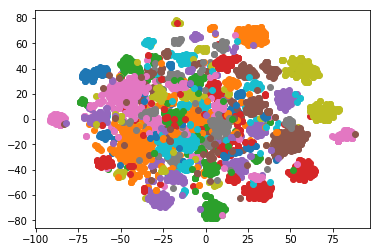

In [20]:
import  matplotlib.pyplot as plt
label = np.array(label)

for i in set(label):
    index = np.where(label==i)
    plt.plot(tsne[index][:,0],tsne[index][:,1],'o',label = i)

### 3 Kmeans 聚类实现

In [144]:
class K_Means(object):
    # k是分组数；tolerance‘中心点误差’；max_iter是迭代次数
    def __init__(self, k=2, tolerance=0.0001, max_iter=300):
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter

    def fit(self, data):
        self.centers_ = {}
        for i in range(self.k_):
            self.centers_[i] = data[i]

        for i in range(self.max_iter_):
            self.clf_ = {}
            for i in range(self.k_):
                self.clf_[i] = []
            for feature in data:
                distances = []
                for center in self.centers_:
                    # 欧拉距离
                    # np.sqrt(np.sum((features-self.centers_[center])**2))
                    distances.append(np.linalg.norm(feature - self.centers_[center]))
                classification = distances.index(min(distances))
                self.clf_[classification].append(feature)

            # print("分组情况:",self.clf_)
            prev_centers = dict(self.centers_)
            for c in self.clf_:
                self.centers_[c] = np.average(self.clf_[c], axis=0)

            # '中心点'是否在误差范围
            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False
            if optimized:
                break

    def predict(self, p_data):
        distances = [np.linalg.norm(p_data - self.centers_[center]) for center in self.centers_]
        index = distances.index(min(distances))
        return index

In [152]:
model = K_Means(k = 86,max_iter=1000) ## 已知86
model.fit(tfidf)
result = []
for d in tfidf:
    result.append(model.predict(d))

/home/blueberry/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/blueberry/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/blueberry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/blueberry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


#### 可视化测试

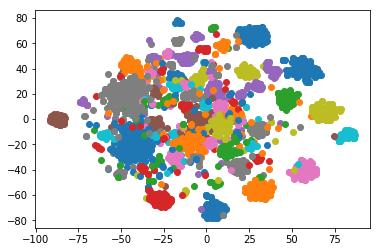

In [153]:
for i in set(result):
    index = np.where(label==i)
    plt.plot(tsne[index][:,0],tsne[index][:,1],'o',label = i)

### 4 sklearn 结果

In [138]:
from sklearn.cluster import KMeans
import time

now = time.time()
kmeans_model=KMeans(n_clusters=86)
y1=kmeans_model.fit_predict(tfidf)
print('time',time.time()-now)

time 66.66124200820923


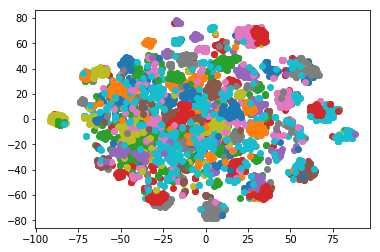

In [139]:
for i in range(max(y1)):
    index = np.where(y1==i)
    plt.plot(tsne[index][:,0],tsne[index][:,1],'o',label = i)